# CA2 Demo - Alex Wright

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math

from keras import Model
from keras import Input
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping

from keras.utils import load_img, img_to_array, array_to_img, save_img
from keras.saving import load_model
from keras.preprocessing import image_dataset_from_directory
from keras.applications import ResNet50

## Mounting to Drive

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = "./drive/My Drive/homl-ca2"
else:
    base_dir = "."

Mounted at /content/drive


In [3]:
example_dir = os.path.join(base_dir, "examples")

## Reading in the model to test

In [4]:
best_network = load_model(os.path.join(base_dir, "transfer_model.keras"))

## Loading the images from the `example` folder

In [5]:
example_images = image_dataset_from_directory(
    directory=example_dir, labels=None, shuffle=False, image_size=(224, 224), batch_size=None)
test_images = tf.convert_to_tensor([example_image for example_image in example_images])

Found 10 files.


## Having a look at the `example` images

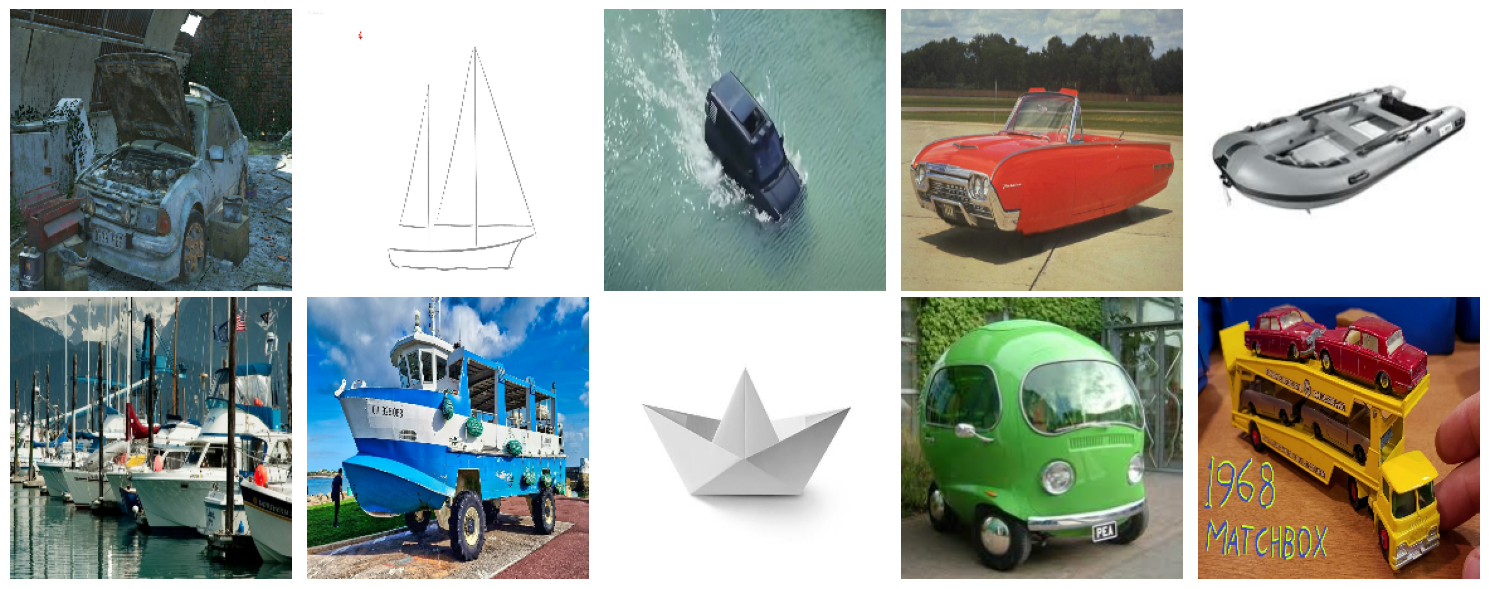

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, image in enumerate(test_images):
  if i < len(axes):
    axes[i].imshow(image / 255.0)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

I have chosen these images (numbered 1-5 in the first row, and 6-10 on the second row) each for a specific reason:
1. This car has it's bonnet up, covering the windshield, which could be a standout feature. The image is also from a video game so the image is quite noisy.
2. This is a drawing of a boat, so it will be interesting to see if the model is learning the characteristics of a boat (shape of the body, sails etc.).
3. This is an image of a car in the water. I chose this image to see if the model is learning a shortcut of water and classifying all images with water in it as a boat, or is it actually learning the general features of a car.
4. This is a picture of a car with no wheels. Since wheels are a standout feature that boats don't have, I want to test is the model learning a shortcut of seeing wheels and associating it with a car.
5. This is a picture of a dingy. It doesn't have any water or wheels, but I thought it would be interesting to see would the model consider it's shape and features be closer to those of a car rather than a boat.
6. This is a picture of a harbor of boats. There is a lot of crowding and sails masts overlapping, which could impede the model's decision.
7. This is a picture of a boat "carrier" it seems. The main reason I chose this image was again, to see if the model associates wheels with cars even though there is clearly a boat in the picture.
8. This is an image of an origami paper boat. I thought it would be interesting to see how the model would classify this.
9. This is an image of a 'joke' car that doesn't have a huge resemblence to the cars seen in the training phase, so I'd like to see how the model will handle its classification.
10. Finally, this is an image of a toy truck carrying some cars. I wanted to see was the model treating the scale of the images as something to take into the decision of classification.

First of all, let's see how this model classifies each of our example images.

In [7]:
predictions = best_network.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


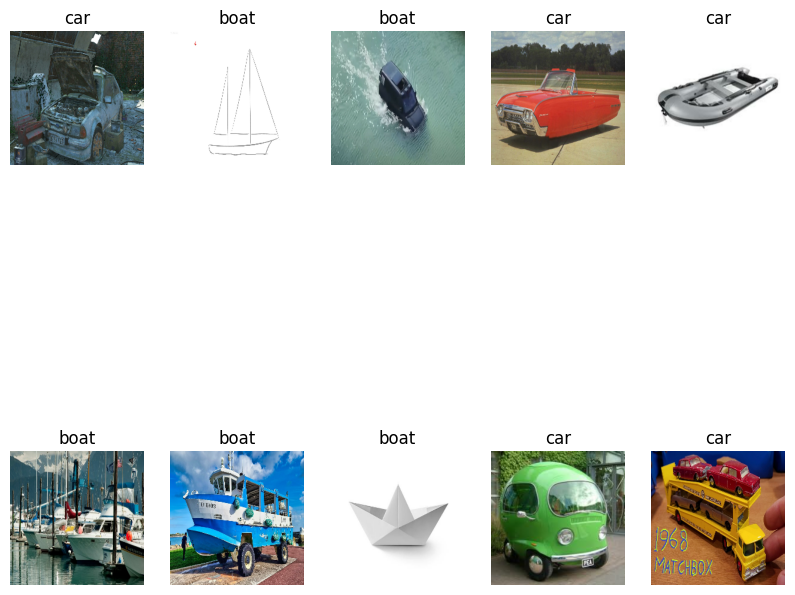

In [8]:
titles = np.where(predictions > 0.5, "car", "boat")
plt.figure(figsize=(10, 10))
for i in range(len(test_images)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(titles[i][0])
    plt.axis("off")
plt.show()

It seems like the model is classifying all but two of the example images correctly! The model got the picture of the dingy and the picture of the car submerged in water wrong. This seems to indicate that the model hasn't learned any shortcuts, which makes sense since our model uses the base of the `resnet50` model, which has been trained on a massive dataset of 1.4 million images. Since the model already knows different types of cars (e.g. 'jeep') and different types of baots (e.g. 'speedboat') we are just telling the model that all the different types of cars fall into one category and each type of boat falls in another. It'll be interesting to explore exactly what the model 'sees' and how it uses what it 'sees' to make its decisions. Potentially what led to the model classifying the dingy as a car instead of a boat, and the submerged car as a boat.

To accomplish this we can use a combination of heatmaps and neuron activation visualisations.

## Visualising the activations of the convolutional layers and pooling layers

In [9]:
# since we didn't unfreeze the weights and biases of the base of the resnet50 model, we can just import it again - also avoided some trouble accessing the base of the `best_network`
resnet50_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
layer_outputs = []
layer_names = []
for layer in resnet50_base.layers:
    if isinstance(layer, (Conv2D, MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = Model(resnet50_base.input, layer_outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's use the 7th image, which is the boat on land with wheels as I believe this to have many features we want to see is the model learning.
- The shape of the boat
- The presence of water
- The presence of wheels

In [10]:
img = load_img(os.path.join(example_dir, "is-it-a-boat-or-is-it-a-car.jpg"), target_size=(224, 224))
img_array = img_to_array(img)
img_tensor = np.expand_dims(img_array, axis=0)

In [11]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [12]:
images_per_row = 16

# Iterate over the layers
for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
    # show every 5 layers as to not flood the output of the notebook
    if i % 5 == 0:
      # This is the number of features in the feature map
      n_features = layer_activation.shape[-1]

      # The feature map has shape (1, size, size, n_features)
      size = layer_activation.shape[1]

      # We will tile the activation channels in this matrix
      n_cols = n_features // images_per_row
      display_grid = np.zeros(((size + 1) * n_cols -1,
                              images_per_row * (size + 1) -1))

      # We'll tile each filter into this big horizontal grid
      for col in range(n_cols):
          for row in range(images_per_row):
              channel_index = col * images_per_row + row
              channel_image = layer_activation[0, :, :, channel_index].copy()
              # Post-process the feature to make it visually palatable
              if channel_image.sum() != 0:
                  channel_image -= channel_image.mean()
                  channel_image /= channel_image.std()
                  channel_image *= 64
                  channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype("uint8")
              display_grid[
                  col * (size + 1): (col + 1) * size + col,
                  row * (size + 1): (row + 1) * size + row] = channel_image
      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect="auto", cmap="viridis")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

We can see above, that the early convolutional layers look for more primitive features such as edges, while the later layers look for more high-level features, such as the shape of the body of the boat, or the wheels of the car. By the last layers. We see the feature maps having large areas of activation showing the presence of the feature or not (i.e. is there a boat in the picture or is there a car).

For instance there is a feature map in one of the final convolutional layers that appears in the visualization as:

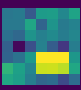

If we compare this to the original image:

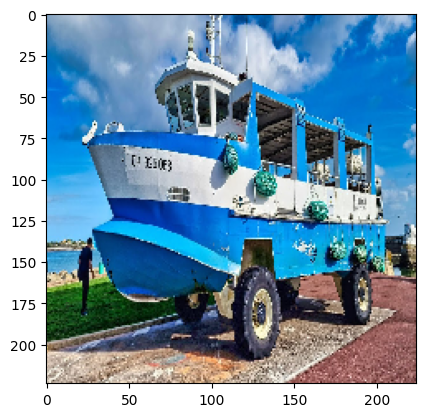

In [13]:
plt.imshow(img)
plt.show()

We can imagine that it's plausible that this feature map corresponds to the presence of wheels in the image. As there is a lot of activation in the neurons associated with the part of the image that there are wheels in. We can see that the later layers focus more on higher-level features, such as a windshield or wheels that then lead to the classification of the image.

## Visualizations of heatmaps that show which parts of the image contribute most to a classification

In [14]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                     self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = image * alpha + heatmap * (1 - alpha)
        output = output.astype(int)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## Creating the heatmap for our image

In [15]:
preds = best_network.predict(img_tensor)
i = np.argmax(preds[0])
cam = GradCAM(best_network.get_layer("resnet50"), i)
heatmap = cam.compute_heatmap(img_tensor)
heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, img_array, alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


Plotting the original image next to it's heatmap, and then overlaying the heatmap onto the image

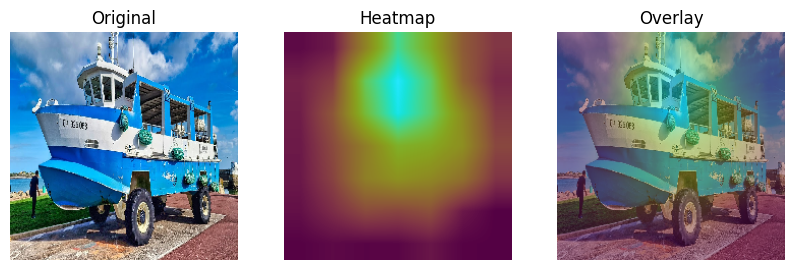

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(output); plt.title("Overlay"); plt.axis("off")
plt.show()

This is a good indication of what our model seems to be focusing on. The bright part of the heatmap is focused on the helm of the boat, and is activating around the general shape of the boat. The model seems to be ignoring features such as the faint water in the distance, and the grass which could've led to it classifying this image as a car.

Let's also observe the heatmap for the image of the dingy, one of the images that the model failed to classify correctly

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


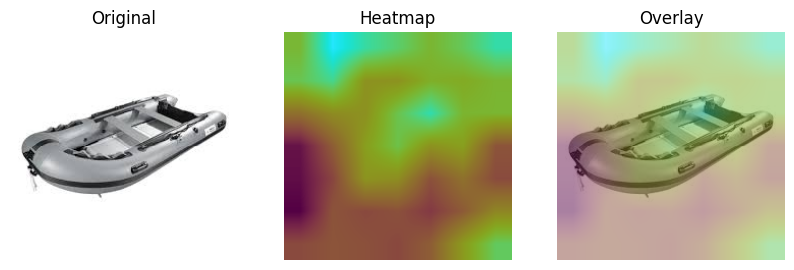

In [17]:
img = load_img(os.path.join(example_dir, "dingy.jpg"), target_size=(224, 224))
img_array = img_to_array(img)
img_tensor = np.expand_dims(img_array, axis=0)

preds = best_network.predict(img_tensor)
i = np.argmax(preds[0])
cam = GradCAM(best_network.get_layer("resnet50"), i)
heatmap = cam.compute_heatmap(img_tensor)
heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, img_array, alpha=0.5)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(output); plt.title("Overlay"); plt.axis("off")
plt.show()


This heatmap seems to be a little more spread, with the model focusing on the interior and the side-structure of the dingy, rather than the whole shape. This probably led to the misclassification, as the model could very well have been trained on images of the inside of cars, which could look similar to the inside of this dingy. The model seems to have focused on textural features, which could resemble seats, or the doors of a car.

The model seems to have ignored the outer inflatable exterior of the boat, which is a large visual clue that could've led to the proper classification of this image.

As we saw in the previous model, it seems that the model focuses more on the exact object in the frame, and isn't really focusing on contextual clues and the environment. This is also an especially hard image since there is no background, but however, there were other images in the `examples` set that didn't have a background, such as the 'boat drawing' and the 'origami boat'.

I think that this model would benefit further from inflatable boats, or maybe boats that don't have such distinct features, such as sails, found on most other types of boats. It could benefit from further data augmentation, where there is more focus on the shape rather than some textural clues.

We can also view the heatmaps for the other images, to ensure that it's focusing on the correct features.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


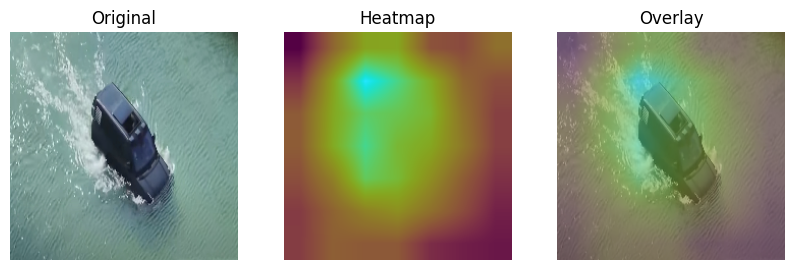

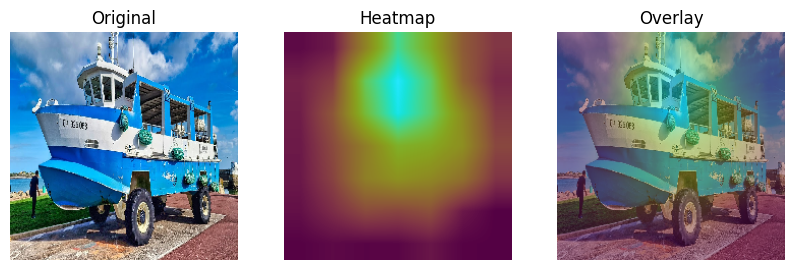

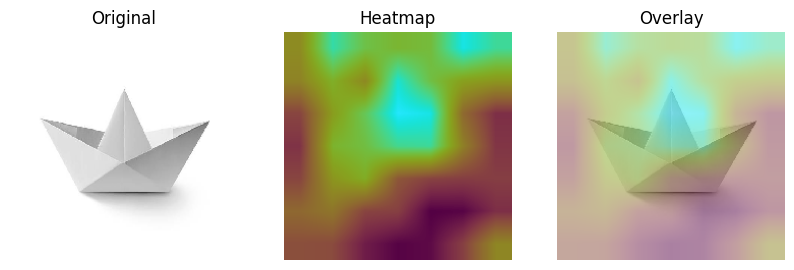

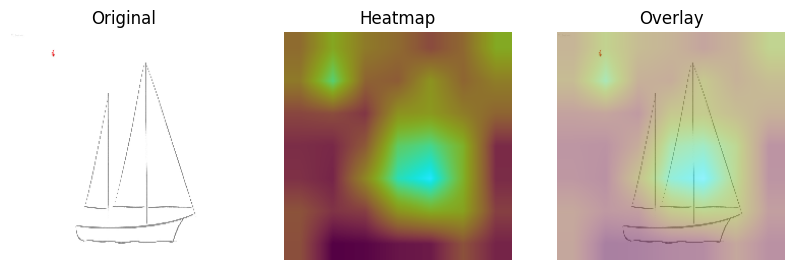

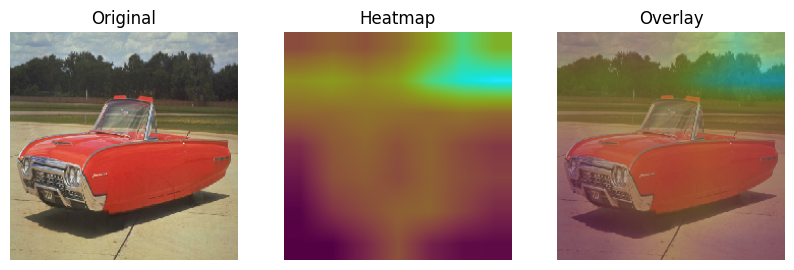

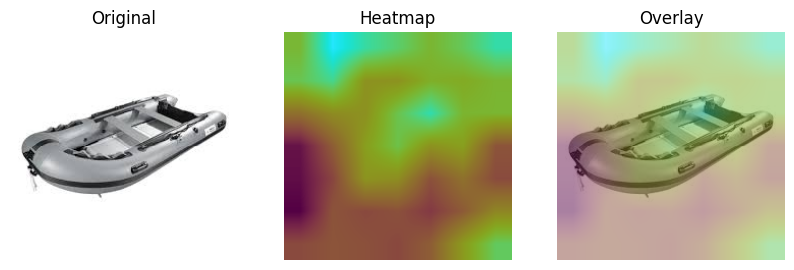

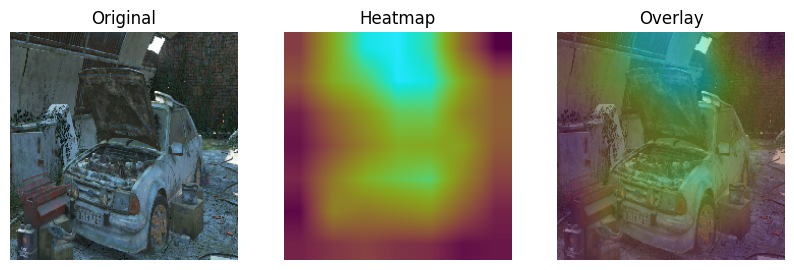

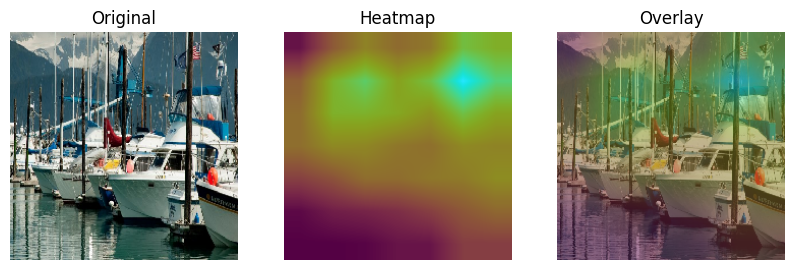

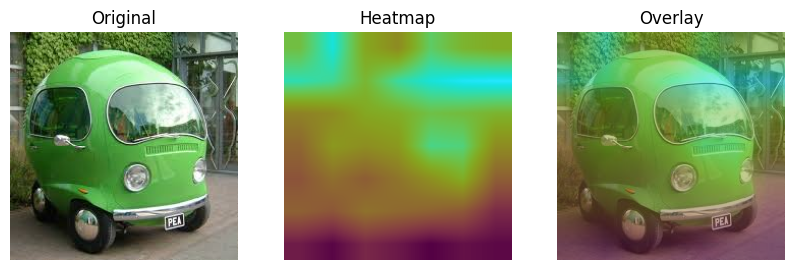

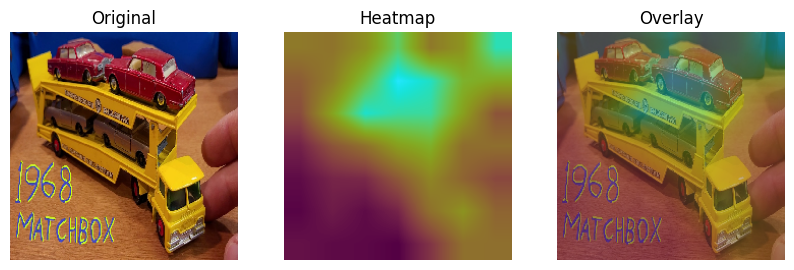

In [18]:
for image in os.listdir(example_dir):
  image_path = os.path.join(example_dir, image)
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_tensor = np.expand_dims(img_array, axis=0)

  preds = best_network.predict(img_tensor)
  i = np.argmax(preds[0])
  cam = GradCAM(best_network.get_layer("resnet50"), i)
  heatmap = cam.compute_heatmap(img_tensor)
  heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
  (heatmap, output) = cam.overlay_heatmap(heatmap, img_array, alpha=0.5)
  plt.figure(figsize=(10,4))
  plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
  plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Heatmap"); plt.axis("off")
  plt.subplot(1,3,3); plt.imshow(output); plt.title("Overlay"); plt.axis("off")
plt.show()

It seems the model mostly focuses on the vehicle/boat in each of the pictures, with the brightest areas of the saliency map over the body. For example in the picture of the car in the water, the majority of the heat is over the car and isn't focusing on the water, which I believed could've been a source for a shortcut. However this still doesn't tell us why this image was misclassified.

In the images of the drawing of the boat, and the paper boat, the brightest areas are over distinctive features of a boat, in these cases the sails. This shows the model seems to be learning the general features of the boat.

One notable exception to this seems to be in the picture of the red convertible car, with no wheels. Originally this image was chosen to see does the model look for wheels and associate that with a car, and while this doesn't seem to be the case, the model instead seems to be focusing on the trees in the background. This could be a possible shortcut as there probably weren't many pictures in the training data with trees near boats. In researching other ways to make what neural networks learn more explainable I came across a technique called Occlusion Sensitivity. We can use it to occlude (cover) parts of the image (in this case the trees) to see what the model decides to use in its classification.

In [19]:
# The code in this cell was generated with the help of Microsoft Copilot

def occlusion_sensitivity(model, image, target_class=None, patch_size=15, stride=8):
    h, w, _ = image.shape
    sensitivity_map = np.zeros((h, w))

    # Get model input size
    target_h, target_w = model.input_shape[1:3]

    # Preprocess original image
    image_resized = cv2.resize(image, (target_w, target_h))
    image_input = np.expand_dims(image_resized, axis=0).astype(np.float32) / 255.0

    # Get raw logits
    preds = model.predict(image_input, verbose=0)[0]

    if target_class is None:
        target_class = np.argmax(preds)

    base_logit = preds[target_class]

    # Slide patch across original image
    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            occluded = image.copy()
            patch = occluded[y:y+patch_size, x:x+patch_size]
            # replacing the patch with a blurred version section
            occluded[y:y+patch_size, x:x+patch_size] = cv2.GaussianBlur(
                patch, (21, 21), sigmaX=0
            )
            # Resize to model input size
            occluded_resized = cv2.resize(occluded, (target_w, target_h))
            occluded_input = np.expand_dims(occluded_resized, axis=0).astype(np.float32) / 255.0

            preds_occ = model.predict(occluded_input, verbose=0)[0]
            occ_logit = preds_occ[target_class]

            # Difference in logits (not softmax)
            drop = base_logit - occ_logit
            sensitivity_map[y:y+patch_size, x:x+patch_size] += drop

    # Normalize safely
    max_val = sensitivity_map.max()
    if max_val > 0:
        sensitivity_map /= max_val
    return sensitivity_map


We will now overlay this sensitivity map over the original image to find out, if we were to cover pieces of the image, how far would the models confidence vary. The 'warm' areas are areas that, when covered drastically increase the confidence of the model. The areas in blue are areas, when covered don't vary the confidence of the model much.


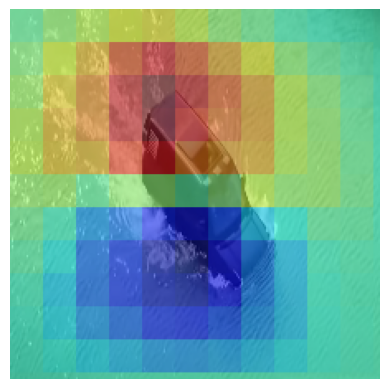

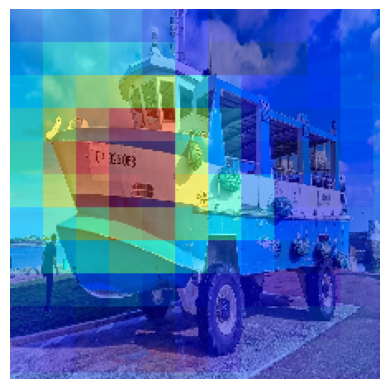

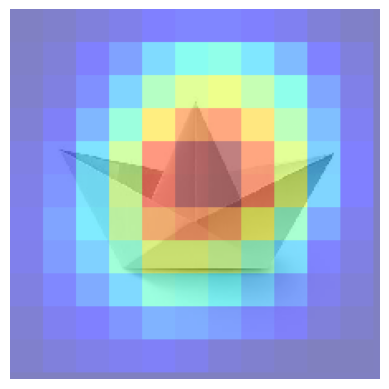

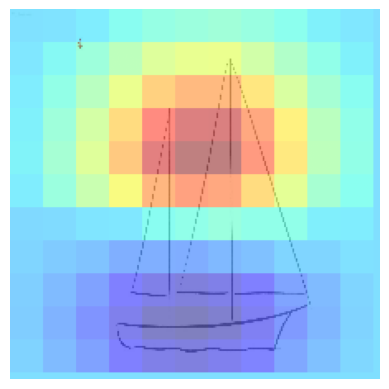

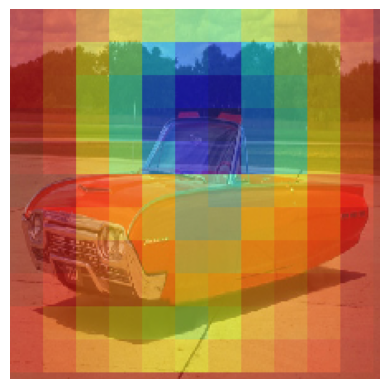

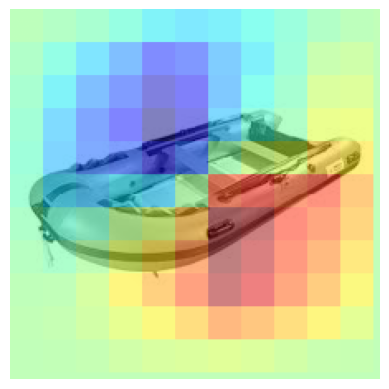

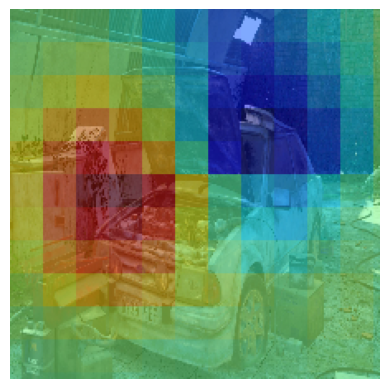

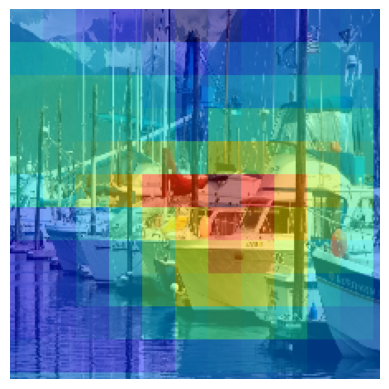

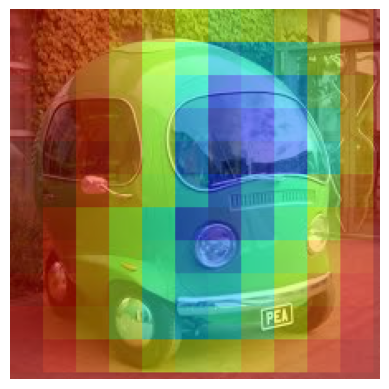

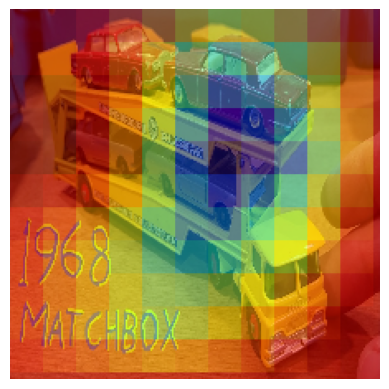

In [20]:
for image_path in os.listdir(example_dir):
  image = load_img(os.path.join(example_dir, image_path), target_size=(224, 224))
  image = img_to_array(image)
  heatmap = occlusion_sensitivity(best_network, image, patch_size=100, stride=20)
  plt.imshow(image.astype(np.uint8))
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  plt.axis("off")
  plt.show()


We can make the following observations based on the sensitivity map over each of our example images:
1. We can see that the area around the back of the car is red meaning that it causes a high change in confidence when removed. A good sign is that most of the water is dark blue, meaning that if it's removed it doesn't change the confidence of the model. This shows us that the model is more focused on the car and doesn't rely on the water to make an inference. This leaves it still unclear as to why this image was misclassified.
2. We can see that similar to the saliency map that the hull / bow of the boat is the area that matters most to the model when removed. This consistency shows us that the model seems to be learning the general shape of the boat.
3. In the image of the paper origami boat, we can see that the 'sails' are the most important aspect of the boat. Leading to its correct classification.
4. In the image of the drawing of the boat, we can see that the red area is over the sails and the mast, which are distinctive features of the boat. This is a really good sign since, this picture is a very primitive representation of a boat that probably wasn't seen during the training phase. This shows us that our model is still able to find the features typical of a boat in a simple image like this.
5. In the image of the car with no wheels, we can see that the 'hot' area of the sensitivity map is over the center of the body, and contradicts our worry with the model 'looking at' the trees in the background. It's clear that these don't matter if blurred / removed. The model seems to focus more on areas like the grille at the front and the shape of the body at the back.
6. In the picture of the dingy (the only image that the model misclassified), we can see that the back of the dingy is of a greater importance than the front. This could be because the front is more 'rounded' and thus more similar to a car. This is one weakness of the model, which could be refined by more training on inflatable or irregularly shaped boats and cars.
7. In the image of the car from the video game, we can see that the bonnet is the area that matters most to the model when removed. Again this is showing us the model cares more about distinctive car features.
8. In the noisy image of the harbor, we can see an excellent example of where out model performs well. We can clearly see that the most obvious boat in the picture is red in the heatmap, while all the noise is blue.
9. In the picture of the 'pea' car we can see that the model cares more about the other features of the car, such as the wheels and registration rather than the irregular shape of the cars body. This is a strength for the model as it further shows it can make an inference based on many different features.
10. Finally, in the image of the toy truck, it matters more if we remove the front part of the truck, which has the distinct features of a car/vehicle. These features include the bonnet, the registration plate, and the windshield of the vehicle.